In [150]:
import numpy

import scipy
from scipy.spatial import distance_matrix

#%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('error', category=UnicodeWarning)

import time
import gzip
import os

from IPython.display import clear_output

# K-means

In [35]:
#def split_nearest(x, centers):
#    '''Split x to groups,
#    the nearest center for each element of i-th group is centers[i]'''
#    assert len(x.shape) == 2
#    cl = distance_matrix(x, centers, p=2).argmin(axis=1)
#    return [x[cl == i] for i in range(centers.shape[0])]

class k_means:
    def __init__(self, k, init=None):
        if init is None:
            init = self._random_choice
        self.init = init
        self.nclusters = k
        self.centers = None

    @staticmethod
    def _random_choice(n, x):
        return (numpy.random.default_rng(seed=numpy.random.randint(0, 2**32))
                .choice(x, size=n, replace=False))

    def train(self, x):
        # get random centers
        self.centers = self.init(self.nclusters, x)
        __import__('__main__').C = self.centers
        prev = None
        while (prev != self.centers).all():
            cl = self.clusters(x)
            # new centers are means of each group
            new = numpy.array([
                    x.mean(axis=0) if len(x) else self.centers[i]
                    for i, x in enumerate(cl)])
            self.centers, prev = new, self.centers
        return self

    def __call__(self, x):
        assert self.centers is not None
        return distance_matrix(x, self.centers, p=2).argmin(axis=1)
    
    def clusters(self, x):
        assert len(x.shape) == 2
        cl = self(x)
        return [x[cl == i] for i in range(self.centers.shape[0])]

### testing

In [3]:
def init_farthest(n, x):
    y = (numpy.random.default_rng(seed=numpy.random.randint(0, 2**32))
            .choice(x, size=1))
    for i in range(n-1):
        y = numpy.concatenate([
                (x[distance_matrix(x, y, p=2).min(axis=1).argmax()]
                        .reshape(1, -1)),
                y])
    return y

def init_plusplus(n, x):
    y = (numpy.random.default_rng(seed=numpy.random.randint(0, 2**32))
            .choice(x, size=1))
    for i in range(n-1):
        probs = distance_matrix(x, y, p=2).min(axis=1) ** 2
        probs /= probs.sum()
        cs = numpy.cumsum(probs)
        r = numpy.random.rand()
        y = numpy.concatenate([
            x[(cs < r) & (probs != 0)][0:1],
            y])
    return y

In [4]:
def clustering_loss(clusters):
    avg = 0
    for c in clusters:
        n = len(c)
        avg += distance_matrix(c, c, p=2).mean() / n
    cc = numpy.concatenate(clusters)
    n = len(cc)
    return avg#/ ((distance_matrix(cc, cc, p=2).mean()) / n)

In [41]:
def gen1(N=100):
    st = numpy.array([1.5 + abs(numpy.random.randn(N)) * 3,
            numpy.random.randn(N)-3])
    st[1] /= st[0]
    x = numpy.concatenate([numpy.random.randn(N, 2)/3,
            2 + numpy.random.randn(N, 2)/3,
            st.T])
    return x

def gen2(N=100, std=1/3, r=1):
    alp = numpy.random.rand(N) * 2 * numpy.pi
    r = r + numpy.random.randn(N) * std
    x = numpy.array([r * numpy.cos(alp), r * numpy.sin(alp)]).T
    return x

def gen3(N=1000, dims=100, c=10, d=10):
    n = N % c
    N //= c
    x = numpy.concatenate([numpy.random.randn(N + n * (not i), 1) * d
            + numpy.random.randn(N + n * (not i), dims) for i in range(c)])
    return x

179679194
0.08459146136486166


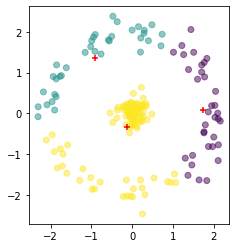

0.058730038934610485


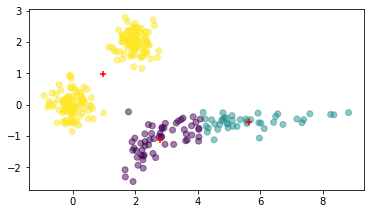

In [6]:
if 1:
    s = numpy.random.randint(0, 2**32-1)
    print(s)
    numpy.random.seed(s)
else:
    numpy.random.seed(3368459579)

kcl = k_means(3, init_farthest)
xx = [numpy.concatenate([gen2(100, 1/5, 2), gen2(100, 1/4, 0)]),
      gen1(100)]
for x in xx:
    kcl.train(x)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.scatter(x[:, 0], x[:, 1], c=kcl(x), alpha=0.5)
    plt.scatter(kcl.centers[:, 0], kcl.centers[:, 1], c='red', marker='+')
    print(clustering_loss(kcl.clusters(x)))
    plt.show()

In [7]:
for name, kcl in [('k-means++', k_means(3, init_plusplus)),
        ('k-means', k_means(3)),
        ('farthest', k_means(3, init_farthest))]:
    print(name)
    for i, x in enumerate(xx):
        gg = x
        kcl.train(gg)
        print(sum([(kcl.train(gg), clustering_loss(kcl.clusters(gg)))[1]
                for i in range(1000)]))
    print()

k-means++
86.63693874623611
32.99972586866253

k-means
87.89381199603942
39.1480138580445

farthest
87.09978094370352
56.301669200385405



# Time

It is almost linear

### 2D

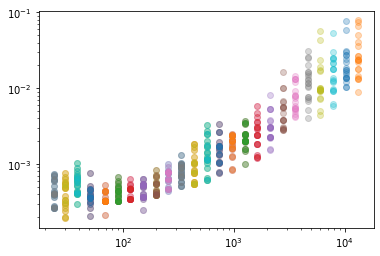

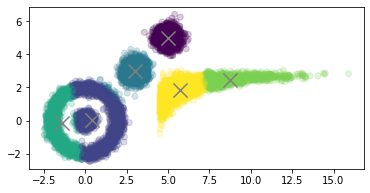

CPU times: user 4.58 s, sys: 16.4 ms, total: 4.59 s
Wall time: 4.59 s


In [19]:
%%time

t = []
sz = 3 * numpy.floor(1.3 ** numpy.arange(8, 53)).astype(numpy.int64)
lt = 0
removed = None

for N in sz:
    training = False
    try:
        assert N%3 == 0
        xx = numpy.concatenate([gen2(N//3, 1/5, 2), gen2(N//3, 1/4, 0), 3 + gen1(N//3)])
        kcl = k_means(6)  # creating model
        t.append([])
        for i in range(20):
            training = True
            t[-1].append(time.time())
            kcl.train(xx)  # training
            t[-1][-1] = time.time() - t[-1][-1]
            training = False
        if time.time() - lt > 1:
            plt.xscale('log')
            plt.yscale('log')
            for s, tt in zip(sz[:len(t)], t):
                plt.scatter(s * numpy.ones(len(tt)), tt, alpha=0.3)
            clear_output(wait=True)
            plt.show()
            lt = time.time()
    except KeyboardInterrupt:
        if training:
            removed = t[-1].pop()
        break
        
        
clear_output(wait=True)
if removed is not None:
    print('removed', removed)
plt.xscale('log')
plt.yscale('log')
for s, tt in zip(sz[:len(t)], t):
    plt.scatter(s * numpy.ones(len(tt)), tt, alpha=0.3)
plt.show()
N = 10000
xx = numpy.concatenate([gen2(N//3, 1/5, 2), gen2(N//3, 1/4, 0), 3 + gen1(N//3)])
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(xx[:, 0], xx[:, 1], c=kcl(xx), alpha=0.2)
plt.scatter(kcl.centers[:, 0], kcl.centers[:, 1], 200, c='gray', marker='x')
plt.show()

### 100D

removed 1605190164.9507964


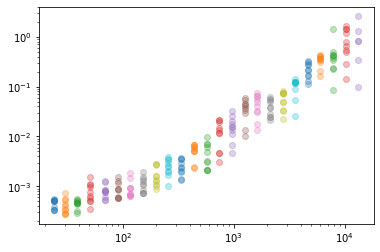

CPU times: user 32.6 s, sys: 65.2 ms, total: 32.6 s
Wall time: 32.6 s


In [44]:
%%time

t = []
sz = 3 * numpy.floor(1.3 ** numpy.arange(8, 53)).astype(numpy.int64)
lt = 0
removed = None

for N in sz:
    training = False
    try:
        assert N%3 == 0
        xx = gen3(N, 100)
        kcl = k_means(6)  # creating model
        t.append([])
        for i in range(10):
            training = True
            t[-1].append(time.time())
            kcl.train(xx)  # training
            t[-1][-1] = time.time() - t[-1][-1]
            training = False
        if time.time() - lt > 1:
            plt.xscale('log')
            plt.yscale('log')
            for s, tt in zip(sz[:len(t)], t):
                plt.scatter(s * numpy.ones(len(tt)), tt, alpha=0.3)
            clear_output(wait=True)
            plt.show()
            lt = time.time()
    except KeyboardInterrupt:
        if training:
            removed = t[-1].pop()
        break
        
        
clear_output(wait=True)
if removed is not None:
    print('removed', removed)
plt.xscale('log')
plt.yscale('log')
for s, tt in zip(sz[:len(t)], t):
    plt.scatter(s * numpy.ones(len(tt)), tt, alpha=0.3)
plt.show()

# MNIST experiments

In [151]:
def load_MNIST_file(url, label=False, directory='.'):

    if directory[-1] != '/':
        directory += '/'
    fname = directory + url[url.rfind('/') + 1 :]
    if not os.path.exists(fname):
        os.system('curl {0} > {1}'.format(url, fname))
    file = gzip.open(fname, 'r')
    if not label:
        # see FILE FORMATS FOR THE MNIST DATABASE on yann.lecun.com/exdb/mnist
        file.read(16)
        image_size = 28
    else:
        # see FILE FORMATS FOR THE MNIST DATABASE on yann.lecun.com/exdb/mnist
        file.read(8)
        image_size = 1
    buf = file.read()
    data = numpy.frombuffer(buf, dtype=numpy.uint8)
    if not label:
        data = data.reshape(-1, image_size, image_size)
    file.close()
    return data

def get_MNIST(directory):
    train_image_url =  'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
    train_labels_url = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
    test_image_url =   'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'
    test_labels_url =  'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
    return (load_MNIST_file(train_image_url, False, directory),
            load_MNIST_file(train_labels_url, True, directory),
            load_MNIST_file(test_image_url, False, directory),
            load_MNIST_file(test_labels_url, True, directory))

In [152]:
directory_for_MNIST = 'MNIST-dataset'
if not os.path.exists(directory_for_MNIST):
    os.mkdir(directory_for_MNIST)
x_train, y_train, x_test, y_test = get_MNIST(directory_for_MNIST)
x_train.shape[0], y_train.shape, x_test.shape[0], y_test.shape

(60000, (60000,), 10000, (10000,))

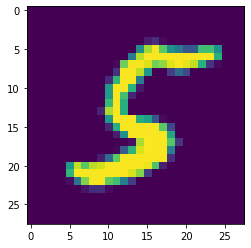

5


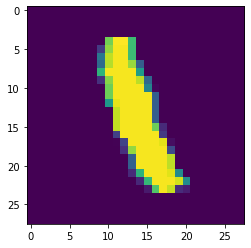

1


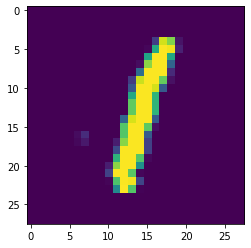

1


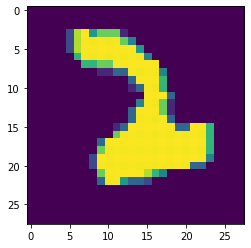

2


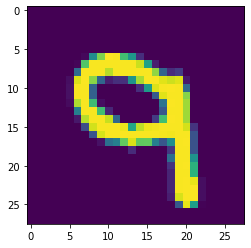

9


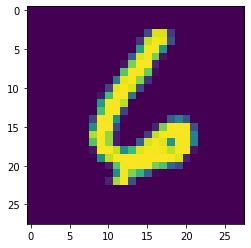

6


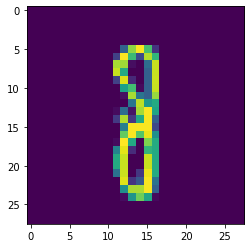

8


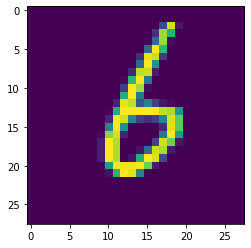

6


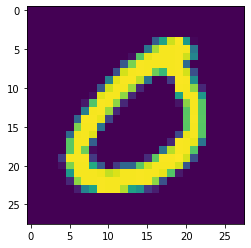

0


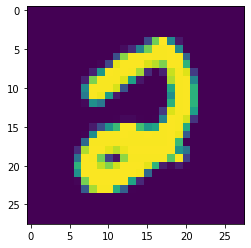

2


In [153]:
for i in numpy.random.randint(0, x_train.shape[0], size=10):
    plt.imshow(x_train[i])
    plt.show()
    print(y_train[i])